Back in [January 2022](https://www.notion.so/Generative-QA-datasets-prospection-e12c08fcc1654db1b4d3cb6e1c9ab5b2#c3318815c5214b6ab5e3799a1cf1f408), I started playing around w/ MS Marco dataset. 



In [1]:
from collections import defaultdict
from statistics import mean

import datasets

import pandas as pd
import numpy as np

import json
import hashlib


import spacy
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])


def generate_uuid(content, indent: int = 2) -> str:
    """Deterministic uuid generator of the `content`."""
    content = json.dumps(content, sort_keys=True, indent=indent).encode("utf-8")
    return hashlib.md5(content).hexdigest()

# Consider this for evaluation of MS Marco:
# https://github.com/microsoft/MSMARCO-Question-Answering/blob/8ecc639c02f697e0b434d0ca04a6528537c20407/Evaluation/eval_exp.py#L22

/home/kat/miniconda3/envs/gqa-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


```python
{
    'answers': array(['No Answer Present.'], dtype=object),
    'passages': {
        'is_selected': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
        'passage_text': [
            'Trust to build up to 1.1M sq. ft. mixed-use site on former IKEA parcel to serve. 4,500 Partners employees. SOMERVILLE. – The state’s largest private employer, Partners HealthCare, will be the first. major industry tenant to take up occupancy in Somerville’s new Assembly Row. neighborhood. The nonprofit healthcare provider plans to build up to 1.1. million square feet of new mixed-use office space in several phases on the.',
             'RSS Feed: Pictured in the photo, left to right. SOMERVILLE – Partners HealthCare formally broke ground on its new administrative offices in Assembly Square yesterday that will bring approximately 4,500 permanent and 1,500 construction jobs to the 45-acre Assembly Row development.',
             'I am thrilled that Partners HealthCare is coming to Assembly Row. The entire area is one of the most vibrant sections of the City and the recent opening of an Orange Line MBTA stop has made it easier to enjoy all that Assembly Row has to offer.',
             'A rendering of the new offices for Partners HealthCare proposed for Assembly Square in Somerville. Globe Staff August 27, 2014. Partners HealthCare, one of the state’s largest nonprofits, has agreed to pay Somerville more than 1 million a year when it moves 4,500 employees to new offices in Assembly Square. The payments are in lieu of local property taxes, which nonprofits, such as hospitals and universities, are exempt from paying.',
             'The Partners Healthcare building in Assembly Row – just over the line from Everett and Charlestown – will eventually bring close to 4,000 hospital administration workers to the area from 14 locations currently spread out all over Greater Boston – including many workers nearby in the Schrafft’s Building in Charlestown.',
             "Monday, December 01, 2014. PARTNERS HEALTHCARE BREAKS GROUND IN SOMERVILLE. Assembly Row's first major industry tenant bringing 4,500 jobs to new office and retail building; Curtatone, Capuano, Gottleib & other officials mark start of construction.",
             'Partners Building in Assembly Row Scheduled to Open June 13. It’s been going up in the distance for some time. Floor by floor, the glass exterior has risen up to its 13-story height, and the promise of nearly 4,000 workers coming into the area has also been on the horizon.',
             'SOMERVILLE - Partners HealthCare formally broke ground on its new administrative offices in Assembly Square yesterday that will bring approximately 4,500 permanent and 1,500 construction jobs to the 45-acre Assembly Row development.',
             '“It is a 13-story building,” said Rich Copp of Partners Healthcare. “We’re ready to open the building with the goal of it beginning on June 13. To be clear, it’s going to take at least 18 months for all of the employees to get under one roof. When it is finished, it will be close to 4,000 employees at that location.”.',
             "Partners Care Decisions. Making it easier to get the right care for you. Partners Care Decisions is a program that helps patients make health care decisions that are right for them. It combines their background, doctors' expertise, and data about other similar patients to ultimately help improve their quality of life."
    ],
      'url': [
          'http://www.somervillema.gov/news/partners-healthcare-build-ikea-site',
         'http://www.partners.org/Newsroom/Press-Releases/Assembly-Square-Office-Ground-Breaking.aspx',
         'http://www.somervillema.gov/news/partners-healthcare-breaks-ground-somerville',
         'https://www.bostonglobe.com/business/2014/08/26/partners-healthcare-developing-offices-somerville-agrees-pay-city-million-year/QRMaPM21gqypRVe8EDnlhO/story.html',
         'http://charlestownbridge.com/2016/06/04/partners-building-in-assembly-row-scheduled-to-open-june-13/',
         'http://www.somervillema.gov/news/partners-healthcare-breaks-ground-somerville',
         'http://charlestownbridge.com/2016/06/04/partners-building-in-assembly-row-scheduled-to-open-june-13/',
         'http://www.somervillema.gov/news/partners-healthcare-breaks-ground-somerville',
         'http://charlestownbridge.com/2016/06/04/partners-building-in-assembly-row-scheduled-to-open-june-13/',
         'https://www.partners.org/']
      },
 'query': 'partners healthcare assembly row phone number',
 'query_id': 471988,
 'query_type': 'NUMERIC',
 'wellFormedAnswers': []}
 ```



Let us compute the same information as we did for MOCHA:
- `num_passages`
- `num_ques_ref_pairs`
- `num_instances`
- `avg_annots_per_ques_ref_pair`	
- `pct_ref_cont_overlap`
- `pct_ref_ques_overlap`
- `avg_passage_len`
- `avg_question_len`
- `avg_reference_len`
- `avg_candidate_len`
- `avg_candidate_scores`

Plus, we also want information about: 
- `num_no_answer`
- `num_well_formed_answers`

In [2]:
# Number of individual passages: for any repeated passage
# we'll observe a repeated count
num_paragraphs = defaultdict(int)

# Number of contexts: for any repeated context
# we'll observe a repeated count
num_contexts = defaultdict(int)

# Number of questions: compute number of questions
num_questions = defaultdict(int)

# Number of passage-question pairs: 
# how many times we repeat the same question
num_paragraph_question_pairs = defaultdict(int)


def build_context(example, sep=" \n "):
    passages = example["passages"]
    example["context"] = sep.join(passages["passage_text"])
        
    context_uuid = generate_uuid(example["context"])
    num_contexts[context_uuid] += 1.0
    
    for passage in passages["passage_text"]:
        uuid_passage = generate_uuid(passage)
        
        # Update counts
        num_paragraphs[uuid_passage] += 1.0
    return example


def populate_num_questions(example):        
    question_uuid = generate_uuid(example["query"])
    num_questions[question_uuid] += 1.0

    return example


def populate_num_answers(example):
    answers = example["answers"]
    answers = filter(lambda s: s.lower() != "no answer present.", answers)
    example["num_answers"] = len(list(answers))
    example["num_passages_selected"] = sum(example["passages"]["is_selected"])
    
    example["num_reviewed_answers"] = len(example["wellFormedAnswers"])
    return example


def num_para_ques_pairs(example):
    for passage in example["passages"]["passage_text"]:
        pair = example["query"] + passage
        pair_uuid = generate_uuid(pair)
        num_paragraph_question_pairs[pair_uuid] +=1

    return example


def compute_len_statistics(example, tokenizer=nlp):
    example["context_len"]  = len(tokenizer(example["context"]))
    example["question_len"] = len(tokenizer(example["query"]))
    example["paragraphs_len"] = mean([len(nlp(passage)) for passage in example["passages"]["passage_text"]])
    
    if example["num_answers"] != 0:
        example["answers_len"] = mean([len(nlp(answer)) for answer in example["answers"]])
    else:
        example["answers_len"] = 0.0
    
    # Compute length of wellFormedAnswers
    if example["num_reviewed_answers"] == 0:
        example["reviewed_answers_len"] = 0.0
    else:
        example["reviewed_answers_len"] = float(mean([len(nlp(answer)) for answer in example["wellFormedAnswers"]]))

    return example


def pct_answers_overlap(example) -> int:
    def _overlap(col1, col2):
        overlap_counts = [
            1 if answer.lower() in example[col1].lower() else 0.0
            for answer in example[col2]
        ] or [0.0]
        example[f"avg_{col2}_{col1}_overlap"] = float(round(mean(overlap_counts), 1))

    _overlap_with_context = lambda col: _overlap("context", col)
    _overlap_with_question = lambda col: _overlap("query", col)
    
    _overlap_with_context("answers")
    _overlap_with_question("answers")
    
    _overlap_with_context("wellFormedAnswers")
    _overlap_with_question("wellFormedAnswers")    
    return example

In [6]:
num_paragraphs

defaultdict(int, {})

In [3]:
def get_statistics_for_split(dataset_split, n=None):
    raw_dataset = datasets.load_dataset("ms_marco", 'v2.1', split=dataset_split)
    
    if n:
        raw_dataset = raw_dataset.shuffle(seed=42).select(range(n))
    
    # -------------------------------------------------------------------
    # 
    # Results
    # 
    # -------------------------------------------------------------------
    statistics = {}

    # Create context
    raw_dataset = raw_dataset.map(build_context)

    # Collects questions
    raw_dataset = raw_dataset.map(populate_num_questions)

    # Computes the number of answers, abstractive, and unawnswerable answers.
    raw_dataset = raw_dataset.map(populate_num_answers)

    # Computes the number of paragraph-question pairs
    raw_dataset = raw_dataset.map(num_para_ques_pairs)

    # Counts
    statistics['num_passages'] = len(num_contexts)
    statistics['num_paragraphs'] = len(num_paragraphs)
    statistics['num_questions'] = len(num_questions)
    statistics["num_instances"] = len(raw_dataset)

    # Count number of unique paragraph/passage question pairs
    statistics['num_paragraph_question_pairs'] = len(num_paragraph_question_pairs)

    # Count number of answers
    statistics["num_answers"] = sum(raw_dataset["num_answers"])
    statistics["num_passages_selected"] = sum(raw_dataset["num_passages_selected"])
    statistics["num_reviewed_annotations"] = sum(raw_dataset["num_reviewed_answers"])


    # Count average annotations statistics
    statistics["avg_num_answers"] = mean(raw_dataset["num_answers"])
    statistics["avg_num_passages_selected"] = mean(raw_dataset["num_passages_selected"])

    # Compute average length statistics
    raw_dataset = raw_dataset.map(pct_answers_overlap)
    raw_dataset = raw_dataset.map(compute_len_statistics)
    statistics["avg_context_len"] = mean(raw_dataset["context_len"])
    statistics["avg_paragraph_len"] = mean(raw_dataset["paragraphs_len"])
    statistics["avg_question_len"] = mean(raw_dataset["question_len"])
    statistics["avg_answers_len"] = mean(raw_dataset["answers_len"])


    # Compute num reviewed answers
    # Compute overlapping statistics
    subset_answers_only = raw_dataset.filter(lambda example: example["num_answers"] != 0)
    statistics["pct_answers_cont_overlap"] = mean(subset_answers_only["avg_answers_context_overlap"])
    statistics["pct_answers_ques_overlap"] = mean(subset_answers_only["avg_answers_query_overlap"])

    subset_reviewed_answers = raw_dataset.filter(lambda example: example["num_reviewed_answers"] != 0)
    statistics["avg_num_reviewed_answers"] =  mean(subset_reviewed_answers["num_reviewed_answers"])
    statistics["avg_reviewed_answers_len"] = mean(subset_reviewed_answers["reviewed_answers_len"])

    statistics["pct_reviewed_cont_overlap"] = mean(subset_reviewed_answers["avg_wellFormedAnswers_context_overlap"])
    statistics["pct_reviewed_ques_overlap"] = mean(subset_reviewed_answers["avg_wellFormedAnswers_query_overlap"])

    return statistics, raw_dataset, subset_reviewed_answers


dev_stats, dataset, subset_reviewed_answers = get_statistics_for_split("validation")

Reusing dataset ms_marco (/home/kat/.cache/huggingface/datasets/ms_marco/v2.1/2.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)
Loading cached processed dataset at /home/kat/.cache/huggingface/datasets/ms_marco/v2.1/2.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84/cache-2ad7261edc61f497.arrow
Loading cached processed dataset at /home/kat/.cache/huggingface/datasets/ms_marco/v2.1/2.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84/cache-6f6efa6b23ac02f1.arrow
Loading cached processed dataset at /home/kat/.cache/huggingface/datasets/ms_marco/v2.1/2.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84/cache-024f6991853740d4.arrow
Loading cached processed dataset at /home/kat/.cache/huggingface/datasets/ms_marco/v2.1/2.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84/cache-b2e2732cd78f2069.arrow
Loading cached processed dataset at /home/kat/.cache/huggingface/datasets/ms_marco/v2.1/2.1.0/b6a6

In [5]:
dev_stats

{'num_passages': 0,
 'num_paragraphs': 0,
 'num_questions': 0,
 'num_instances': 101093,
 'num_paragraph_question_pairs': 0,
 'num_answers': 56634,
 'num_passages_selected': 59273,
 'num_reviewed_annotations': 21023,
 'avg_num_answers': 0.5602168300475799,
 'avg_num_passages_selected': 0.5863215059400749,
 'avg_context_len': 636.7069332199064,
 'avg_paragraph_len': 62.8980925122232,
 'avg_question_len': 6.587726153146113,
 'avg_answers_len': 9.696475522538652,
 'avg_num_reviewed_answers': 1.6862918103794016,
 'avg_reviewed_answers_len': 16.658878360036287,
 'pct_answers_cont_overlap': 0.19841334217008103,
 'pct_answers_ques_overlap': 0.0015085119642309556,
 'pct_reviewed_cont_overlap': 0.19609368733456325,
 'pct_reviewed_ques_overlap': 1.6042351808775166e-05}

In [15]:
subset_answers_only = dataset.filter(lambda example: example["num_answers"] != 0)
print("pct_answers_cont_overlap:", mean(dataset["avg_answers_context_overlap"]))
print("pct_answers_ques_overlap:",  mean(dataset["avg_answers_query_overlap"]))

Loading cached processed dataset at /home/kat/.cache/huggingface/datasets/ms_marco/v2.1/2.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84/cache-6a673b027dbf8b13.arrow


pct_answers_cont_overlap: 0.19841334217008103
pct_answers_ques_overlap: 0.0015085119642309556


In [17]:
print("avg_context_len", mean(subset_reviewed_answers["context_len"]))
print("avg_question_len", mean(subset_reviewed_answers["question_len"]))

avg_context_len 630.0050533408198
avg_question_len 6.190663351247293


In [20]:
subset_reviewed_answers["wellFormedAnswers"]

[['The population of Albany, Minnesota is 2,662. '],
 ['The Volcano forecast for Apr 12 is 52 degrees and Patchy light rain.'],
 ['Hippocrates is considered the father of modern medicine.'],
 ['An appraisal is good for 120 days from the date of the Note for a Fannie loan.',
  'An appraisal is good for a Fannie loan is 120 days from the date of the note.'],
 ['The average salary for a pharmacy technician is $26,000 to $39,000 in a year.',
  'The average salary for a pharmacy technician is from $26,000 to $39,000 a year.'],
 ['An average apple has 80 calories.',
  'There are 80 calories in an average apple.'],
 ['A Central air conditioner lasts for in between 10 and 20 years.',
  'A central air conditioner should last for 10 to 20 years.'],
 ['The animal rescue league hours in summers are on monday 11am to 5pm, on tuesday 11am to 8pm, on thursday 11am to 8pm, on friday 11am to 5pm, on saturday 11am to 4pm.',
  'The animal rescue league hours from April to October are Monday: 11am to 5pm,

In [27]:
import matplotlib.pyplot as plt 
import seaborn as sns 


def plot_lengths(data, col, figsize=(8, 5), **kwargs):
    datum = data[f"{col}_len"]
    print(f"{col}_len [", min(datum), max(datum), "]")
    
    plt.figure(figsize=figsize)
    sns.histplot(datum, label=f"{col}_len", **kwargs)
    plt.legend()
    plt.title(col + " distribution")

answers_len [ 0.0 148.0 ]


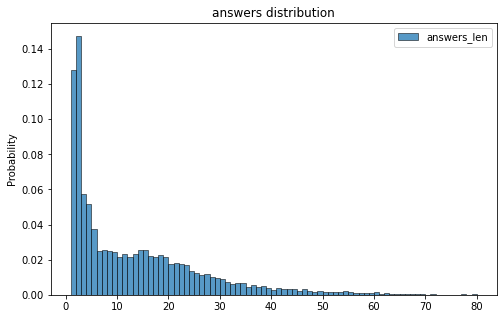

In [38]:
plot_lengths(subset_reviewed_answers, "answers", binwidth=1, binrange=(1, 80), stat="probability")

reviewed_answers_len [ 4.0 125.0 ]


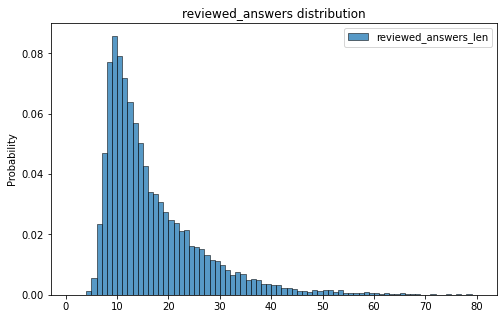

In [36]:
plot_lengths(subset_reviewed_answers, "reviewed_answers", binwidth=1, binrange=(1, 80), stat="probability")